**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. **Use JupyterLab**. Other notebook-editing software (e.g. VSCode, pycharm) might corrupt the notebook files.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

# Deep Learning

In this exercise you will be introduced to some practical aspects of deep learning in computer vision, including constructing a deep neural network and training it via gradient descent to tackle image classification. The PyTorch-framework will be used for this.

We will tackle **image classification** through deep learning methods, in particular we will look at

* Softmax regression with stochastic gradient descent and Adam
* Multilayer perceptrons with tanh and ReLU
* Data augmentation
* A basic convolutional net

### Install PyTorch

Use `conda install -y pytorch torchvision cpuonly -c pytorch` to install PyTorch without GPU support (make sure that the correct conda environment is active). You may also install a GPU-build if you have a compatible GPU, see https://pytorch.org/get-started/locally/. Using a GPU will make the training several times faster, but since not all of you may have one, we have tried to scale this exercise with a CPU in mind.

### TensorBoard Plotting

TensorBoard is a web-based tool for drawing pretty plots of quantities we care about during training, such as the loss. Install it using `conda install -y tensorboard -c conda-forge`.

We need to choose a folder where these values will be stored ("logdir"). Start the TensorBoard server by executing e.g. `tensorboard --logdir tensorboard_logs` after you've activated your conda environment. If you change the logdir, also adjust it in the cell below.

You can view the graphs by visiting http://localhost:6006/#custom_scalars in your browser (6006 is the default port).
Make sure that "Custom Scalars" is selected at the top (not "Scalars") because this will give a better visualization.
At first there will be nothing to plot, so it will be empty.

In [1]:
LOG_ROOT = 'tensorboard_logs'
USE_GPU = False  # Set to True if you have installed tensorflow for GPU

In [2]:
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Just an image plotting function
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=2, imheight=2, share_axes=False):
    """
    Plot multiple images as subplots on a grid. Images must be channel-first
    and between [0, 1].
    """
    images = [np.transpose(im, (1, 2, 0)) for im in images]
    if titles is None:
        titles = [''] * len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def visualize_dataset(dataset, n_samples=24, max_columns=6):
    xs, ys = list(zip(*[dataset[i] for i in range(n_samples)]))
    plot_multiple([x / 2 + 0.5 for x in xs], [labels[i] for i in ys], max_columns=max_columns)

## Dataset Preparation
We are going to tackle the classic image classification task using the **CIFAR-10 dataset**, containing 60,000 32x32 RGB images of 10 different classes (50,000 for training and 10,000 for testing). 

![image.png](cifar.png)

The dataset is automatically downloaded if you run the next cell.
It will take some time , but after the dataset was downloaded once, this will not happen anymore.
You may read more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html.

When initializing the CIFAR-10 dataset, we can specify a transform.
In the example below it does two things: first, it converts the image to tensors which is a PyTorch's way to represent matrices.
They are similar to numpy arrays but allow to store gradients during backpropagation.
For most numpy functions there is a similar function provided by Pytorch.
Secondly, the transform normalizes the data, such that the images are in the range `[-1, 1]`, which is advantageous for learning models.

Note, that for historical reasons PyTorch uses a "channels-first"-format, i.e. the order of the dimensions for an image is `NCHW` (batch-channels-height-width), not `NHWC` (batch-height-width-channels).
This is why the shape of an image is `(3, 32, 32)` instead of `(32, 32, 3)`.

Files already downloaded and verified
Files already downloaded and verified

Shape of an image: torch.Size([3, 32, 32]).


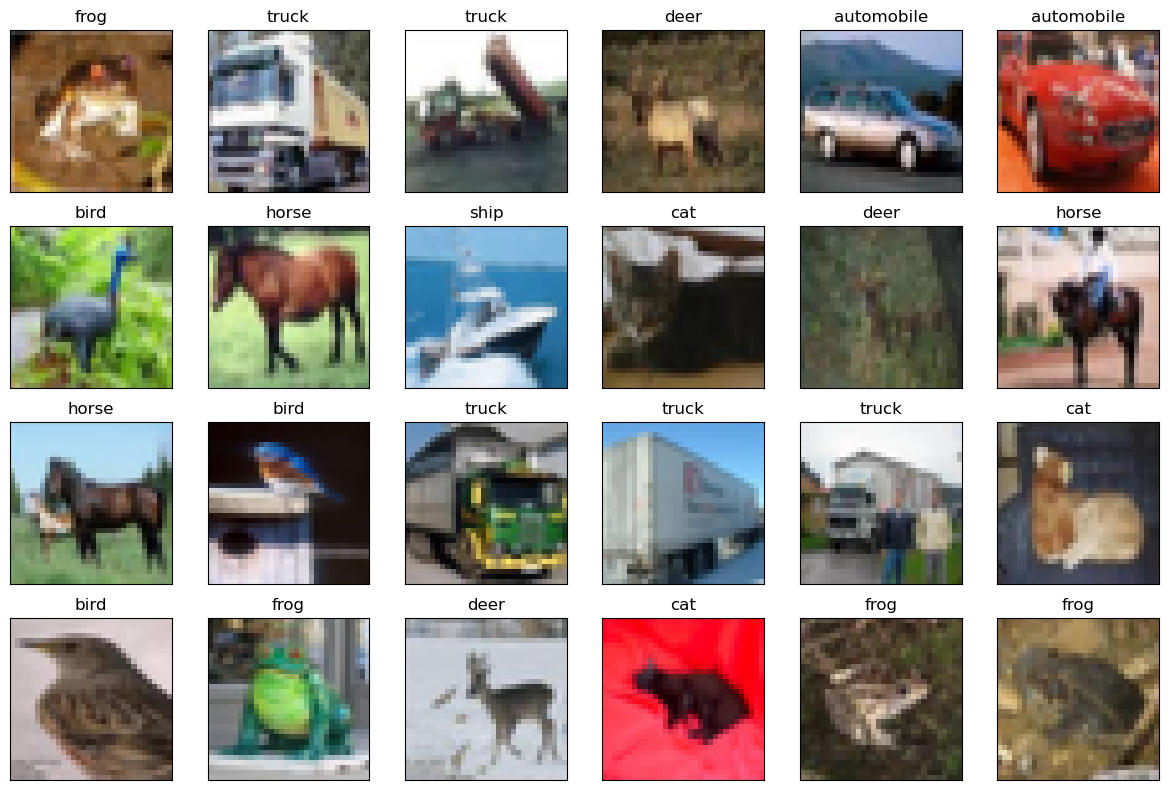

In [3]:
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = CIFAR10(root='cifar10/train/', train=True, download=True, transform=normalize_transform)
test_data = CIFAR10(root='cifar10/test/', train=False, download=True, transform=normalize_transform)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x, y = train_data[0]  # get an example from the dataset
print(f'\nShape of an image: {x.shape}.')
visualize_dataset(train_data)

The final step for dataset preprocessing is defining a dataloader.
This does a few things for us: it produces minibatches of data of a given batchsize, shuffles the order of the training samples randomly, and performs the dataloading in parallel using a few worker processes.
We do this for both train and test split.

In [4]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=128, num_workers=6)

## Softmax Regression

Before considering convolutional neural networks, let us start with a simpler classifier called softmax regression (a.k.a. multinomial logistic regression). Note that even though the name contains "regression", this is a classification model.

Softmax regression can be understood as a single-layer neural network. We first flatten our input image to a long vector $\mathbf{x}$, consisting of $32\cdot 32\cdot 3 = 3072$ values. Then we predict class probabilities $\hat{\mathbf{y}}$ through a fully-connected layer with softmax activation:

$$
\mathbf{z} = W \mathbf{x} + \mathbf{b} \\
\hat{y}_c = \operatorname{softmax}(\mathbf{z})_c = \frac{\exp{z_c}}{\sum_{\tilde{c}=1}^{10} \exp{z_{\tilde{c}}}}
$$

Here $z_c$ denotes the $c$th component of the vector $\mathbf{z}$, called the vector of **logits**.
The weights $W$ and biases $\mathbf{b}$ will be learned during training.

### Training

We train the model by minimizing a **loss function** averaged over the training data. As we are tackling a classification problem, the **cross-entropy** is a suitable loss function:

$$
\mathcal{L}_{CE}(\mathbf{y}, \hat{\mathbf{y}}; W, \mathbf{b}) = - \sum_{c=1}^{10} y_c \log{\hat{y}_c}
$$

Note that in the above notation the ground-truth $\mathbf{y}$ is a so-called **one-hot vector**, containing a single 1 component, while the remaining components 
are zeros. The model's predicted $\hat{\mathbf{y}}$ is a vector which also sums to one, but whose components all take continuous values in the range $(0, 1)$.

We minimize the loss by **stochastic gradient descent** (SGD). That is, we repeatedly sample mini-batches from the training data and update the parameters (weights and biases) towards the direction of the steepest decrease of the loss averaged over the mini-batch. For example, the weight $w_{ij}$ (an element of the matrix $W$) is updated according to:

$$
w_{ij}^{(t+1)} = w_{ij}^{(t)} - \eta \cdot \frac{\partial \mathcal{L}_{CE}} {\partial w_{ij}},
$$

with $\eta$ being the learning rate.

To build such a model in PyTorch, we take a `Sequential` module which accepts layers that are applied sequentially. Here we have two layers: `Flatten` converts the image into a long vector and `Linear` is a synonym for fully-connected layer. At the end we would expect a `Softmax` layer, but this has to be omitted since the PyTorch-implementation of cross-entropy already performs the softmax implicitly. If you check the equations above, you see why this is advantageous: the cross-entropy applies a $\log$ to the $\exp$ of the softmax, which cancel out. By doing both at once, we avoid unnecessary computations and reduce the risk of numerical issues.



In [5]:
# define the model
softmax_regression = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=10)
)
# in case we use GPU, push the model to the GPU
if USE_GPU:
    softmax_regression.cuda()

Next, we need to define the cross-entropy-loss.
This is where the softmax is implicitely computed.

In addition we instantiate an optimizer.
An optimizer receives the parameters from the model and provides functions to automatically perform the backpropagation and the gradient update.

In [6]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(softmax_regression.parameters(), lr=0.1)

Let's do a training step now. We need to do the following:
* Get a batch from the training data
* Do a forward pass through the model
* Compute the loss
* Backpropagate the loss to compute the gradients for each parameter
* Do a weight update using the computed gradients
* Clear the computed gradients to be ready for the next training step

In [7]:
xs, ys = next(iter(train_loader))  # get minibatch
if USE_GPU:  # move data to GPU
    xs = xs.cuda()
    ys = ys.cuda()
out = softmax_regression(xs)  # forward pass
loss = criterion(out, ys)  # compute loss
loss.backward()  # perform backpropagation
opt.step()  # weight update
opt.zero_grad()  # clean up
print('Loss:', loss.item())

Loss: 2.397885799407959


The model does not learn much from a single batch, instead we need to iterate over the full dataloader.
To avoid code duplication, we will now define a generic function which trains a given model for us.

You need to fill three gaps in this function: first, perform the actual training step.
Second, update the training statistics, i.e. `sample_count`, `loss_sum` and `correct_count`.
These are used to compute the training loss and the training accuracy.
Finally, implement the testing loop, which computes test loss and test accuracy with the test set.
  
During this process, several statistics (loss/accuracy for train/test) are computed, printed and written to TensorBoard. The function also supports specifying a learning rate scheduler, which we will use at the end of this exercise.

In [8]:
# POINTS: 7

def train_model(
    model,
    criterion,
    opt,
    logdir,
    train_loader,
    test_loader,
    n_epochs=50,
):
    # stuff for writing to tensorboard
    writer = SummaryWriter(f"{LOG_ROOT}/{logdir}-{time.strftime('%y%m%d_%H%M%S')}")
    layout = {
        'Losses': {'losses': ['Multiline', ['loss/train', 'loss/test']]},
        'Accuracy': {'accuracy': ['Multiline', ['accuracy/train', 'accuracy/test']]}
    }
    writer.add_custom_scalars(layout)
    
    start = time.time()  # get current time for statistics
    for epoch in range(n_epochs):  # iterate over epochs
        model.train()  # set the model to training mode
        # collect some numbers for statistics
        sample_count = 0  # number of seen samples
        loss_sum = 0  # total loss
        correct_count = 0  # total number of correctly classified samples
        n_batches = len(train_loader)  # number of batches
        for i, (xs, ys) in enumerate(train_loader):  # iterate over training set
            # training step
            # YOUR CODE HERE
            # raise NotImplementedError()
            opt.zero_grad()  # zero the parameter gradients
            outputs = model(xs)  # forward pass
            loss = criterion(outputs, ys)  # compute loss
            loss.backward()  # backward pass
            opt.step()  # update model parameters

            # update statistics
            # YOUR CODE HERE
            # raise NotImplementedError()
            loss_sum += loss.item() * xs.size(0)
            sample_count += xs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_count += (predicted == ys).sum().item()
            print(f'Train epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')

        train_loss = loss_sum / sample_count
        train_accuracy = correct_count / sample_count
        
        with torch.no_grad():  # do not store gradients during testing, decreases memory consumption
            model.eval()  # set the model to evaluation mode
            # YOUR CODE HERE
            # raise NotImplementedError()
            test_loss_sum = 0
            test_correct_count = 0
            test_sample_count = 0
            for xs, ys in test_loader:
                outputs = model(xs)
                loss = criterion(outputs, ys)
                test_loss_sum += loss.item() * xs.size(0)
                test_sample_count += xs.size(0)
                _, predicted = torch.max(outputs, 1)
                test_correct_count += (predicted == ys).sum().item()
            
            test_loss = test_loss_sum / test_sample_count
            test_accuracy = test_correct_count / test_sample_count
        
        writer.add_scalar('loss/train', train_loss, epoch+1)
        writer.add_scalar('accuracy/train', train_accuracy, epoch+1)
        writer.add_scalar('loss/test', test_loss, epoch+1)
        writer.add_scalar('accuracy/test', test_accuracy, epoch+1)
            
        print(
            f'Epoch {epoch+1} | train loss: {train_loss:.3f}, train accuracy: {train_accuracy:.3f}, ' + \
            f'test loss: {test_loss:.3f}, test accuracy: {test_accuracy:.3f}, ' + \
            f'time: {str(datetime.timedelta(seconds=int(time.time()-start)))}'
        )

In [9]:
train_model(
    model=softmax_regression,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.SGD(softmax_regression.parameters(), lr=0.1),
    logdir='softmax_regression',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 2.103, train accuracy: 0.319, test loss: 1.944, test accuracy: 0.342, time: 0:00:49
Epoch 2 | train loss: 1.999, train accuracy: 0.351, test loss: 2.261, test accuracy: 0.301, time: 0:01:34
Epoch 3 | train loss: 1.992, train accuracy: 0.361, test loss: 2.071, test accuracy: 0.345, time: 0:02:21
Epoch 4 | train loss: 1.976, train accuracy: 0.365, test loss: 2.145, test accuracy: 0.340, time: 0:03:08
Epoch 5 | train loss: 1.944, train accuracy: 0.372, test loss: 2.172, test accuracy: 0.314, time: 0:03:56
Epoch 6 | train loss: 1.953, train accuracy: 0.370, test loss: 2.048, test accuracy: 0.353, time: 0:04:43
Epoch 7 | train loss: 1.945, train accuracy: 0.372, test loss: 1.899, test accuracy: 0.372, time: 0:05:31
Epoch 8 | train loss: 1.947, train accuracy: 0.378, test loss: 2.286, test accuracy: 0.331, time: 0:06:19
Epoch 9 | train loss: 1.938, train accuracy: 0.377, test loss: 2.202, test accuracy: 0.331, time: 0:07:06
Epoch 10 | train loss: 1.935, train accuracy: 

(Jupyter Notebook Tip: you can collapse or hide the output by clicking or double clicking the area directly to the left of the output.)

You can check the how the loss and accuracy (= proportion of correctly predicted classes) change over the course of training in TensorBoard. What do you observe?

*POINTS: 1*

YOUR ANSWER HERE

The overfitting situation appears.
The loss is smaller and the accuracy is bigger with the epoch increasing but until epoch 10 the loss and the accuracy value starts to go up and down.

## Adam Optimizer

There has been a lot of research on improving on the simple stochastic gradient descent algorithm we used above. One of the most popular variants is called **Adam** (https://arxiv.org/abs/1412.6980, "adaptive moment estimation"). Its learning rate usually requires less precise tuning, and something in the range of $(10^{-4},10^{-3})$ often works well in practice. Intuitively, this is because the algorithm automatically adapts the learning rate for each weight depending on the gradients.

In [10]:
softmax_regression_adam = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=10)
)
if USE_GPU:
    softmax_regression_adam.cuda()

train_model(
    model=softmax_regression_adam,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(softmax_regression_adam.parameters(), lr=2e-4),
    logdir='softmax_regression_adam',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.859, train accuracy: 0.361, test loss: 1.789, test accuracy: 0.388, time: 0:01:06
Epoch 2 | train loss: 1.767, train accuracy: 0.399, test loss: 1.759, test accuracy: 0.396, time: 0:02:15
Epoch 3 | train loss: 1.740, train accuracy: 0.409, test loss: 1.746, test accuracy: 0.403, time: 0:03:24
Epoch 4 | train loss: 1.724, train accuracy: 0.415, test loss: 1.732, test accuracy: 0.405, time: 0:04:29
Epoch 5 | train loss: 1.711, train accuracy: 0.420, test loss: 1.732, test accuracy: 0.400, time: 0:05:38
Epoch 6 | train loss: 1.701, train accuracy: 0.423, test loss: 1.725, test accuracy: 0.410, time: 0:06:47
Epoch 7 | train loss: 1.693, train accuracy: 0.428, test loss: 1.727, test accuracy: 0.405, time: 5:05:48
Epoch 8 | train loss: 1.687, train accuracy: 0.427, test loss: 1.723, test accuracy: 0.408, time: 5:06:34
Epoch 9 | train loss: 1.682, train accuracy: 0.431, test loss: 1.721, test accuracy: 0.410, time: 5:07:21
Epoch 10 | train loss: 1.677, train accuracy: 

## Interpreting the Learned Weights

Multiplication by the weights $W$ can be interpreted as computing responses to correlation templates per image class.

That means, we can reshape the weight array $W$ to a obtain "template images".

Perform this reshaping to visualize the resulting templates.

torch.Size([10, 3072])


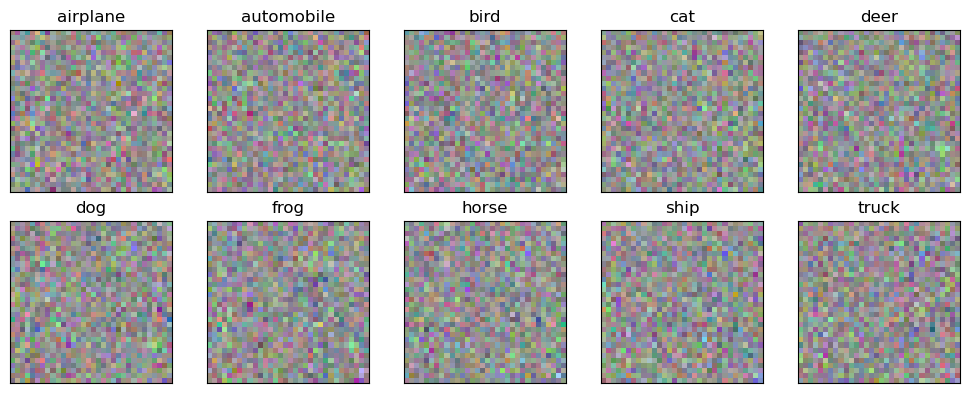

In [11]:
# POINTS: 2

W = softmax_regression[1].weight.data

print(W.shape)
# Use W to create the `templates` variable with dimensions [10 (class count), 3 (rgb), height, width]
# YOUR CODE HERE
# raise NotImplementedError()
templates = W.reshape(32,32,3,10).permute(3,2,1,0)
# We normalize the templates for visualization
mini = templates.min()
maxi = templates.max()
rescaled_templates = (templates - mini) / (maxi - mini)
plot_multiple(rescaled_templates.cpu(), labels, max_columns=5)

Do they look as you would expect?

*POINTS: 2*

YOUR ANSWER HERE

Yes, different class means different weights.

## Multi-Layer Perceptron

Softmax regression has a big limitation: the decision surface between any two classes (i.e. the part of the input space where the classification decision changes from one class to another) is a simple hyperplane ("flat").

The **multi-layer perceptron** (MLP) is a neural network model with additional layer(s) between the input and the logits (so-called hidden layers), with nonlinear activation functions.

Before the current generation of neural networks, the **hyperbolic tangent** (tanh) function used to be the preferred activation function in the hidden layers of MLPs. It is sigmoid shaped and has a range of $(-1,1)$. We can create such a network in PyTorch as follows.

In [12]:
tanh_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    tanh_mlp.cuda()
    
train_model(
    model=tanh_mlp,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(tanh_mlp.parameters(), lr=2e-4),
    logdir='tanh_mlp',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.781, train accuracy: 0.385, test loss: 1.686, test accuracy: 0.420, time: 0:00:56
Epoch 2 | train loss: 1.642, train accuracy: 0.439, test loss: 1.622, test accuracy: 0.441, time: 0:01:52
Epoch 3 | train loss: 1.563, train accuracy: 0.468, test loss: 1.574, test accuracy: 0.461, time: 0:02:48
Epoch 4 | train loss: 1.499, train accuracy: 0.493, test loss: 1.549, test accuracy: 0.471, time: 0:03:44
Epoch 5 | train loss: 1.442, train accuracy: 0.510, test loss: 1.517, test accuracy: 0.483, time: 0:04:41
Epoch 6 | train loss: 1.389, train accuracy: 0.532, test loss: 1.496, test accuracy: 0.490, time: 0:05:37
Epoch 7 | train loss: 1.335, train accuracy: 0.551, test loss: 1.485, test accuracy: 0.492, time: 0:06:34
Epoch 8 | train loss: 1.286, train accuracy: 0.570, test loss: 1.476, test accuracy: 0.494, time: 0:07:31
Epoch 9 | train loss: 1.239, train accuracy: 0.587, test loss: 1.469, test accuracy: 0.494, time: 0:08:28
Epoch 10 | train loss: 1.191, train accuracy: 

Does it obtain better results than the linear model? What do you observe if you compare the accuracy curves for training and testing?

How and why does the behaviour of the test loss differ from the test accuracy?

*POINTS: 3*

YOUR ANSWER HERE

Yes, the augmented model typically performs better due to improved generalization from data augmentations.
Test Loss: Measures prediction confidence and can increase even if accuracy remains stable, indicating overfitting.
Test Accuracy: A discrete measure that might plateau, reflecting the proportion of correct predictions.
Augmentations help reduce overfitting, leading to more consistent test accuracy and potentially lower test loss.

## Data Augmentation

To avoid this effect, we can use data augmentation. By applying small changes to the training samples, we can virtually increase the size of the dataset such that the model cannot memorize training samples as easily.

Have a look at the `torchvision.transforms` module of torchvision and add the following augmentations below:

* shift the images randomly horizontally and vertically by up to 10% of the height and width
* scale the images randomly between 90% and 110%
* mirror the images such that the right and the left side are swapped in 50% of the cases

Files already downloaded and verified


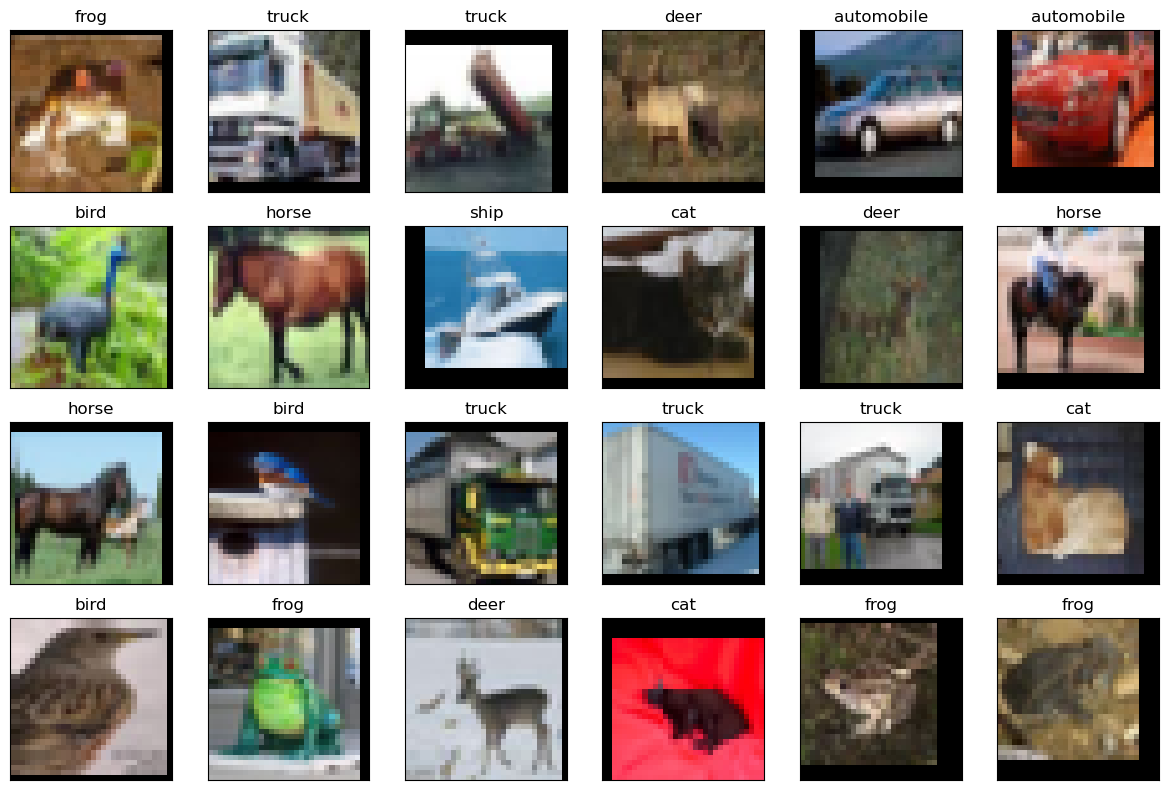

In [13]:
# POINTS: 2

augment_transform = transforms.Compose([
    # YOUR CODE HERE
    # raise NotImplementedError()
    transforms.RandomAffine(
        degrees=0,  # No rotation
        translate=(0.1, 0.1),  # Shift by up to 10% of width and height
        scale=(0.9, 1.1)  # Scale between 90% and 110%
    ),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image with a 50% probability
])

normalize_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image
])
augmented_train_data = CIFAR10(root='cifar10/train/', train=True, download=True,
                               transform=transforms.Compose([augment_transform, normalize_transform]))
visualize_dataset(augmented_train_data)

augmented_train_loader = DataLoader(augmented_train_data, batch_size=128, shuffle=True, num_workers=6)

In [14]:
tanh_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    tanh_mlp.cuda()


train_model(
    model=tanh_mlp,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(tanh_mlp.parameters(), lr=2e-4),
    logdir='tanh_mlp_augmented',
    train_loader=augmented_train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.877, train accuracy: 0.334, test loss: 1.775, test accuracy: 0.385, time: 0:00:58
Epoch 2 | train loss: 1.746, train accuracy: 0.388, test loss: 1.741, test accuracy: 0.398, time: 0:01:58
Epoch 3 | train loss: 1.677, train accuracy: 0.409, test loss: 1.711, test accuracy: 0.408, time: 0:02:56
Epoch 4 | train loss: 1.631, train accuracy: 0.426, test loss: 1.692, test accuracy: 0.416, time: 0:03:57
Epoch 5 | train loss: 1.594, train accuracy: 0.436, test loss: 1.676, test accuracy: 0.421, time: 0:04:58
Epoch 6 | train loss: 1.567, train accuracy: 0.447, test loss: 1.653, test accuracy: 0.426, time: 0:05:59
Epoch 7 | train loss: 1.542, train accuracy: 0.458, test loss: 1.626, test accuracy: 0.437, time: 0:06:59
Epoch 8 | train loss: 1.519, train accuracy: 0.465, test loss: 1.622, test accuracy: 0.438, time: 0:07:58
Epoch 9 | train loss: 1.501, train accuracy: 0.470, test loss: 1.625, test accuracy: 0.436, time: 0:09:05
Epoch 10 | train loss: 1.483, train accuracy: 

What do you observe if you train the same model on the augmented data?

*POINTS: 1*

YOUR ANSWER HERE
Higher Test Accuracy, lower Overfitting, stable Test Loss

## ReLU

The ReLU activation function has become more popular in recent years, especially for deeper nets. Create and train an MLP with the same architecture as above which uses ReLU instead of tanh as the activation.

In [15]:
# POINTS: 4

relu_mlp = nn.Sequential(
    # YOUR CODE HERE
    # raise NotImplementedError()
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    relu_mlp.cuda()

train_model(
    model=relu_mlp,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(relu_mlp.parameters(), lr=2e-4),
    logdir='relu_mlp',
    train_loader=augmented_train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.791, train accuracy: 0.360, test loss: 1.585, test accuracy: 0.446, time: 0:01:30
Epoch 2 | train loss: 1.633, train accuracy: 0.423, test loss: 1.510, test accuracy: 0.472, time: 0:02:49
Epoch 3 | train loss: 1.566, train accuracy: 0.448, test loss: 1.465, test accuracy: 0.483, time: 0:04:09
Epoch 4 | train loss: 1.527, train accuracy: 0.461, test loss: 1.443, test accuracy: 0.493, time: 0:05:29
Epoch 5 | train loss: 1.499, train accuracy: 0.471, test loss: 1.438, test accuracy: 0.496, time: 0:07:09
Epoch 6 | train loss: 1.472, train accuracy: 0.482, test loss: 1.406, test accuracy: 0.507, time: 0:08:57
Epoch 7 | train loss: 1.457, train accuracy: 0.489, test loss: 1.397, test accuracy: 0.509, time: 0:10:41
Epoch 8 | train loss: 1.437, train accuracy: 0.493, test loss: 1.380, test accuracy: 0.512, time: 0:12:16
Epoch 9 | train loss: 1.421, train accuracy: 0.497, test loss: 1.369, test accuracy: 0.520, time: 0:13:53
Epoch 10 | train loss: 1.409, train accuracy: 

KeyboardInterrupt: 

Do the results change? What benefit does ReLU have against tanh?

*POINTS: 1*

YOUR ANSWER HERE
Avoids Vanishing Gradients, sparsity, faster Convergence(because of time pressures, I wtopped the training in advance)

## A Simple Convolutional Neural Network

The previous models did not explicitly make use of the grid structure of the image pixels. Convolutional neural networks do.

Instead of reshaping the input image pixels into one long vector, convolutional layers slide small filters across the input, just as with the convolutional filters we saw earlier in the course. In the earlier parts, we looked at convolution on an image with a single channel in case of grayscale images, or channelwise separate convolutions on RGB images.

In CNNs, the multiple input channels of a conv layer are not handled independently, but are linearly combined. This means that the weight array has shape `[out_channels, in_channels, kernel_height, kernel_width]` and we perform a weighted sum along the input channel axis. Another difference is the use of a **bias** vector of shape `[out_channels]`, each components gets added to the corresponding output channel.

As you already know, convolution is a linear operator, so it is possible to express any convolutional layer as a fully-connected layer.
However, the convolutional layer's weight matrix is sparse (has many zeros) compared to a fully-connected ("linear") layer because each output only depends on a small number of inputs, namely, those within a small neigborhood. Further, the weight values are shared between the different pixel locations.

This tutorial has some great visualisations and explanations on the details of conv layers: https://arxiv.org/abs/1603.07285.

Technically, what's called a "convolutional" layer is usually implemented as a *cross-correlation* computation. Could there be any advantage in using the actual definition of convolution in these layers?

*POINTS: 2*

YOUR ANSWER HERE
Its implementation is simple and efficient.

Train the following simple CNN model. It may take about 30 minutes on a CPU.

In [16]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
)
if USE_GPU:
    cnn.cuda()

train_model(
    model=cnn,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(cnn.parameters(), lr=5e-4),
    logdir='cnn',
    train_loader=augmented_train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.604, train accuracy: 0.425, test loss: 1.291, test accuracy: 0.540, time: 0:02:57
Epoch 2 | train loss: 1.312, train accuracy: 0.538, test loss: 1.143, test accuracy: 0.599, time: 0:06:08


KeyboardInterrupt: 

Does it improve the result? Does it run faster than the MLP?

*POINTS: 1*

YOUR ANSWER HERE
Yes, it is slower.(due to time pressures, I stopped the training in advance)

How many parameters does this model have? How many parameters has the MLP? Show the steps of your computation!

*POINTS: 3*

YOUR ANSWER HERE
cnn: 1792+36928+40970=79790
mlp: 3072*512+512+512*10+10=1578506

## Implementing the Forward Pass

To confirm your understanding of the main CNN components, implement the forward pass of the convolutional, max pooling and dense layers, plus the relu activation function. For simplicity, assume a fixed filter size of 3x3 for the convolution, with stride 1 and use zero padding, such that the spatial size does not change (called 'same' padding). Implement this in `conv3x3_same`. For max pooling assume a fixed 2x2 pooling size and stride 2 in `maxpool2x2`.

To check whether your implementation is correct, we can extract the weights from the PyTorch model we trained above, and feed these weights and an test input to your implementation of the forward pass. If your result disagrees with PyTorch, there is probably a bug somewhere!

In [17]:
# POINTS: 10

def conv3x3_same(x, weights, biases):
    """Convolutional layer with filter size 3x3 and 'same' padding.
    `x` is a NumPy array of shape [in_channels, height, width]
    `weights` has shape [out_channels, in_channels, kernel_height, kernel_width]
    `biases` has shape [out_channels]
    Return the output of the 3x3 conv (without activation)
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    in_channels, height, width = x.shape
    out_channels, _, kernel_height, kernel_width = weights.shape
    
    # Padding the input
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_x = np.pad(x, ((0, 0), (pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    
    # Initialize the output tensor
    result = np.zeros((out_channels, height, width))
    
    # Perform the convolution
    for out_ch in range(out_channels):
        for in_ch in range(in_channels):
            for i in range(height):
                for j in range(width):
                    result[out_ch, i, j] += np.sum(
                        weights[out_ch, in_ch] * padded_x[in_ch, i:i+kernel_height, j:j+kernel_width]
                    )
        # Add the bias
        result[out_ch] += biases[out_ch]
    return result

def maxpool2x2(x):
    """Max pooling with pool size 2x2 and stride 2.
    `x` is a numpy array of shape [in_channels, height, width]
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    in_channels, height, width = x.shape
    
    # Calculate output dimensions
    out_height = height // 2
    out_width = width // 2
    
    # Initialize the output tensor
    result = np.zeros((in_channels, out_height, out_width))
    
    # Perform max pooling
    for ch in range(in_channels):
        for i in range(out_height):
            for j in range(out_width):
                result[ch, i, j] = np.max(x[ch, i*2:i*2+2, j*2:j*2+2])
    
    return result

def linear(x, weights, biases):
    # YOUR CODE HERE
    # raise NotImplementedError()
    return weights @ x + biases
    
def relu(x):
    # YOUR CODE HERE
    # raise NotImplementedError()
    return np.maximum(0, x)

def my_predict_cnn(x, W1, b1, W2, b2, W3, b3):
    x = conv3x3_same(x, W1, b1)
    x = relu(x)
    x = maxpool2x2(x)
    x = conv3x3_same(x, W2, b2)
    x = relu(x)
    x = maxpool2x2(x)
    x = x.reshape(-1)
    x = linear(x, W3, b3)
    return x

W1 = cnn[0].weight.data.cpu().numpy()
b1 = cnn[0].bias.data.cpu().numpy()
W2 = cnn[3].weight.data.cpu().numpy()
b2 = cnn[3].bias.data.cpu().numpy()
W3 = cnn[7].weight.data.cpu().numpy()
b3 = cnn[7].bias.data.cpu().numpy()

inp = train_data[0][0]
inp_np = inp.numpy()
if USE_GPU:
    inp = inp.cuda()
my_logits = my_predict_cnn(inp_np, W1, b1, W2, b2, W3, b3)
pytorch_logits = cnn(inp[np.newaxis])[0]
if np.mean((my_logits-pytorch_logits.detach().cpu().numpy())**2) > 1e-5:
    print('Something isn\'t right! PyTorch gives different results than my_predict_cnn!')
else:
    print('Congratulations, you got correct results!')

Congratulations, you got correct results!
